# **MEDICAL COST ANALYSIS**

# Importing required libraries and data

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale, StandardScaler
import sklearn.metrics as mt

In [4]:
insurance = pd.read_csv("insurance.csv")
df = insurance.copy()
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# EDA

check for missing data:

In [5]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


7 değişkenin 4'ünün numeric, 3'ünün kategorik olduğunu gördük.

Kategorik olanlar: sex, smoker, region

Numeric olanlar: age, bmi, children, charges(hedef değişken)


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Bmi'ya baktığımızda max için 38-40 gibi bir değer beklerken 53 olduğunu görüyoruz. Aykırı değerler olabilir, araştırılmalı.

Children ve age için anormallik görünmüyor.

Charges için 75% ve max arasındaki makas çok büyük görünüyor

**Bmi için aykırı değer var mı kontrolünü sağlayalım:**

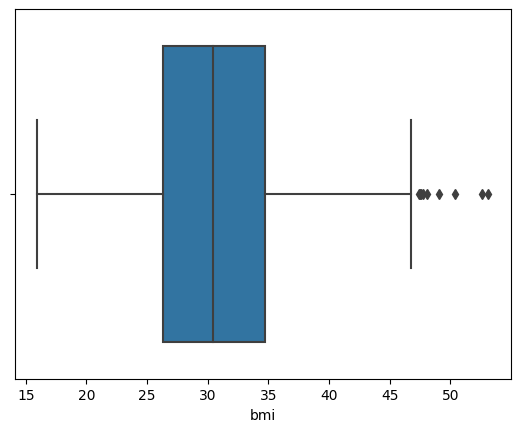

In [13]:
sns.boxplot(x='bmi',data=df);

Değerler 26-35 arasında yığılmış gibi görünüyor. Dağılımı görselleştirerek daha net fikir sahibi olalım:

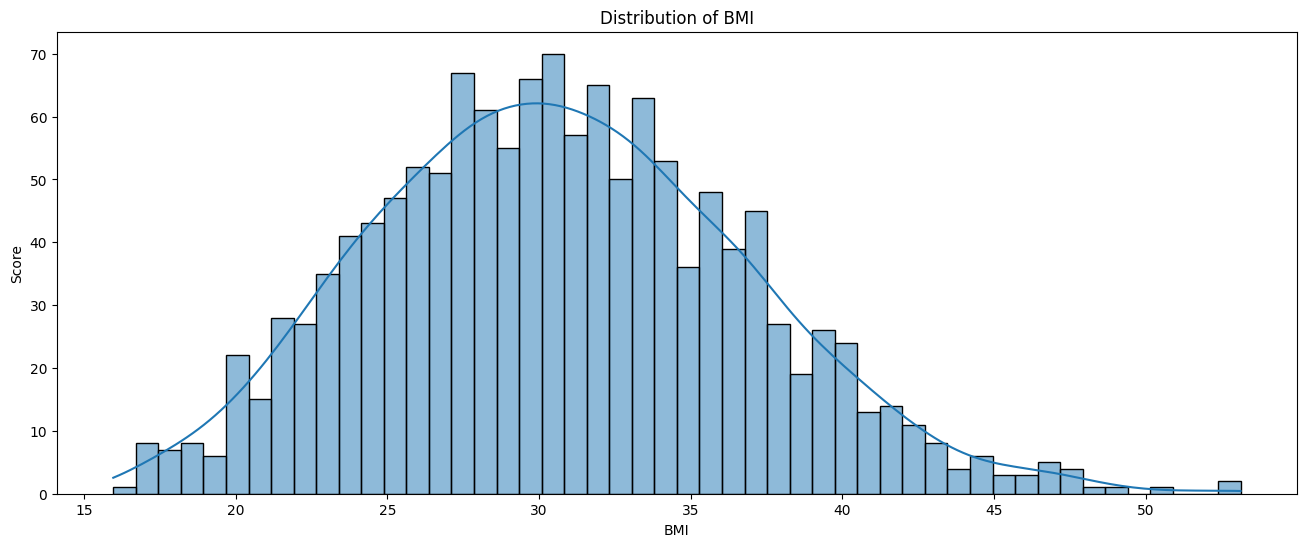

In [16]:
plt.figure(figsize=(16,6))
sns.histplot(df["bmi"], bins = 50, kde = True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Score')
plt.show()

Outlier değerler için IQR methodunu uygulayalım:

IQR = Q3 - Q1 hesapla

Lower Bound: (Q1 - 1.5 * IQR)

Upper Bound: (Q3 + 1.5 * IQR)

Lower ve upper boundları aşan değerleri df'den çıkartalım.

In [19]:
Q1 = df.bmi.quantile(0.25)
Q3 = df.bmi.quantile(0.75)

IQR = Q3 - Q1
IQR

8.3975

In [20]:
lower_bound = (Q1 - 1.5 * IQR)

upper_bound = (Q3 + 1.5 * IQR)

In [21]:
upper_bound, lower_bound

(47.290000000000006, 13.7)

Bmi için min 15.9600, max 53.13000'ti. Bu yüzden lower bound'u aşan bi değer olmadığını görüyoruz. Ancak upper boundu aşan değerler var. Bu değerleri görelim:

In [22]:
df[df['bmi'] > upper_bound]

,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


Bu değerlere sahip indexleri listede toplayıp bu değerleri veri setinden çıkaralım:

In [26]:
selected_rows = df[df['bmi'] > upper_bound]
index_list = selected_rows.index.tolist()
index_list

[116, 286, 401, 543, 847, 860, 1047, 1088, 1317]

In [29]:
df = df.drop(df.index[index_list])

Kontrol etmek için yeniden görüntüleyelim:

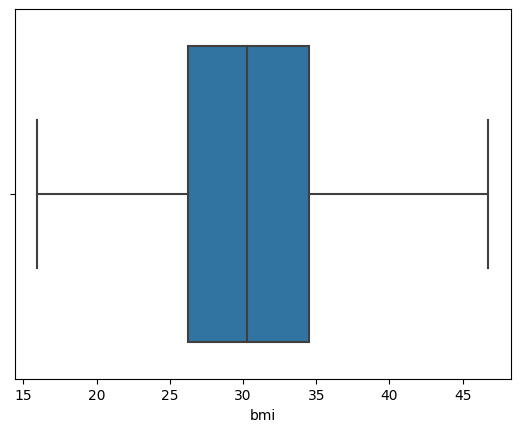

In [30]:
sns.boxplot(x='bmi',data=df);

**Sigara içenleri bölgelere göre inceleyelim:**

Text(0.5, 1.0, 'Smokers according to region')

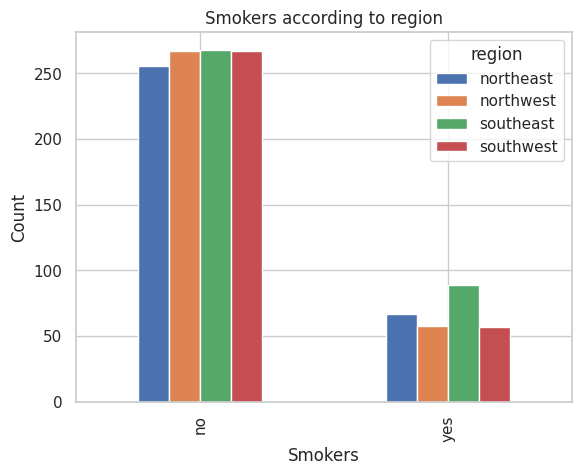

In [37]:
smoker_region=df.groupby("smoker")["region"].value_counts().unstack()
smoker_region.plot(kind="bar")
plt.xlabel("Smokers")
plt.ylabel("Count")
plt.title("Smokers according to region")

Sigara içenler ve içmeyenler genel olarak eşit dağılmış. Ancak southeast'te sigara içenlerin diğer bölgelerdeki sigara içenlere kıyasla daha çok olduğunu söyleyebiliriz.

Bmi ve cinsiyet arasındaki ilişkiyi inceleyelim:

Text(0.5, 1.0, 'BMI according to sex')

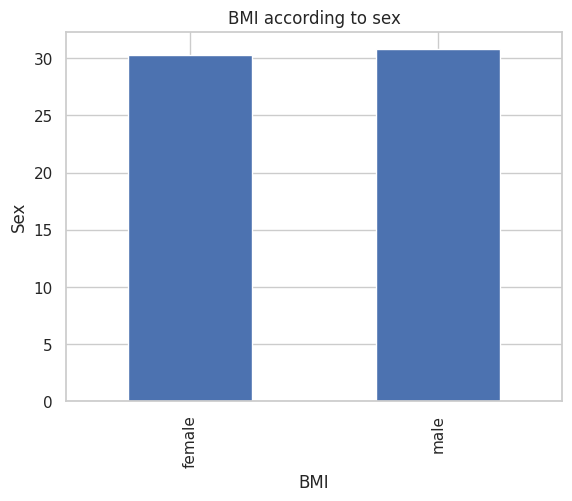

In [39]:
sex_bmi=df.groupby("sex")["bmi"].mean()
sex_bmi.plot(kind="bar")
plt.xlabel("BMI")
plt.ylabel("Sex")
plt.title("BMI according to sex")

Cinsiyet ve bmi arasında önemli bir ilişki yok gibi görünüyor.

Bölgelere göre çocuk sayılarına bakalım:

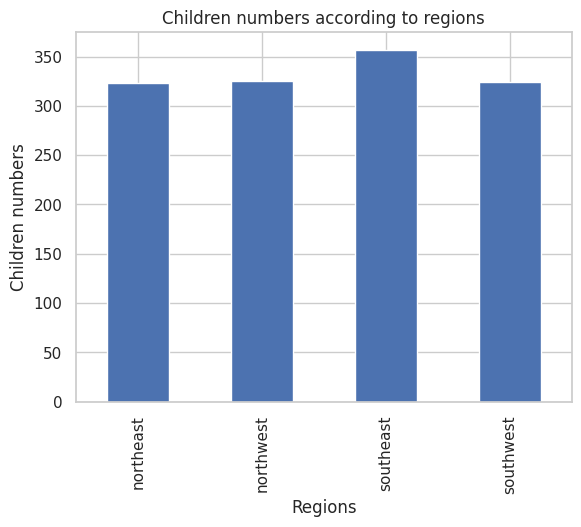

In [43]:
region_child=df.groupby("region")["children"].count()
region_child.plot(kind="bar");
plt.xlabel("Regions")
plt.ylabel("Children numbers")
plt.title("Children numbers according to regions");

Southeastte yaşayanların daha fazla çocuğa sahip olduğunu söyleyebiliriz.

Yaş ile bmi arasındaki ilişkiyi inceleyelim:

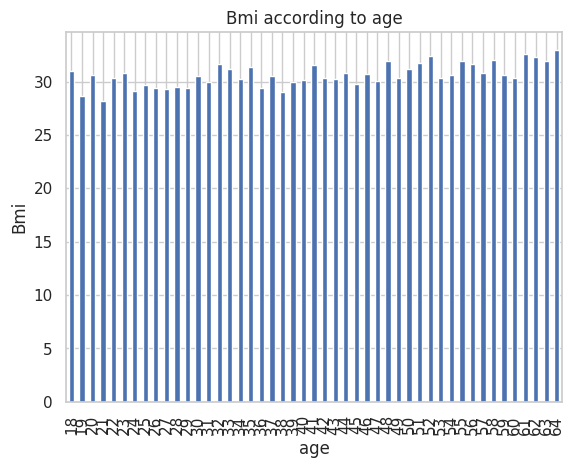

In [47]:
age_bmi=df.groupby("age")["bmi"].mean()
age_bmi.plot(kind="bar")
plt.xlabel("age")
plt.ylabel("Bmi")
plt.title("Bmi according to age");

Genel olarak bmi ve yaş arasında eşit bir dağılım var gibi görünüyor.

Bmi ile çocuk sayısı arasındaki ilişkiyi inceleyelim:

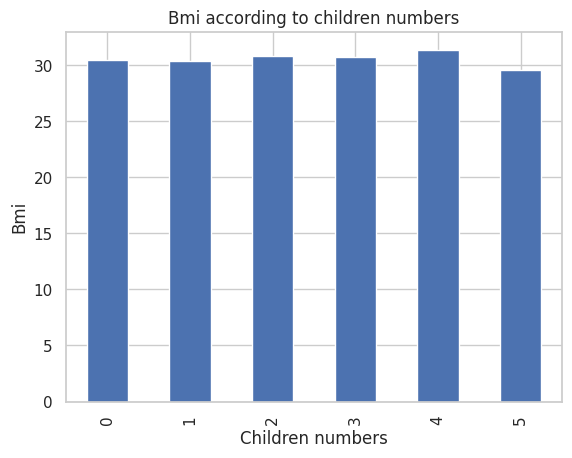

In [45]:
child_bmi=df.groupby("children")["bmi"].mean()
child_bmi.plot(kind="bar")
plt.xlabel("Children numbers")
plt.ylabel("Bmi")
plt.title("Bmi according to children numbers");

Bmi ile çocuk sayısı arasında önemli bir ilişki görüntüleyemedik.

Bmi ile charges arasındaki ilişkiyi inceleyelim:

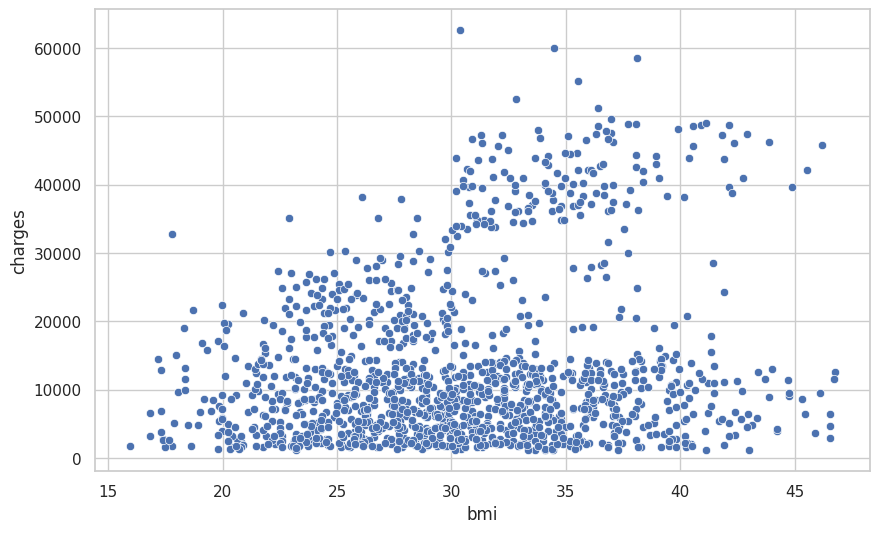

In [54]:
sns.set(style='whitegrid')
f = plt.figure(figsize=(10,6))
sns.scatterplot(x='bmi', y='charges', data=df);

Bmi arttıkça masrafların arttığını söyleyebiliriz.

Bölge, sigara içme durumu ve bmi arasındaki ilişkiyi inceleyelim:

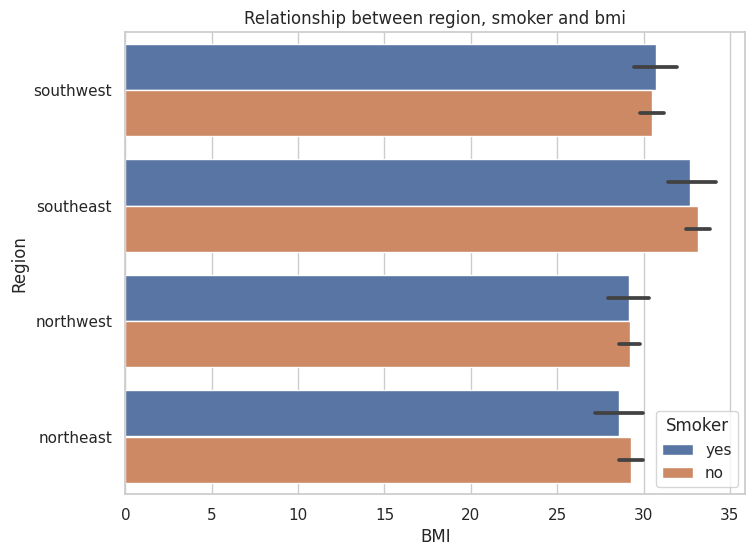

In [55]:
plt.figure(figsize=(8,6))
sns.barplot(x="bmi", y="region", hue="smoker", data=df)
plt.title("Relationship between region, smoker and bmi")
plt.xlabel("BMI")
plt.ylabel("Region")
plt.legend(title="Smoker")
plt.show()

Sigara içme durumundan bağımsız olarak southeasttekilerin bmi değerleri hafifçe daha yüksek.

Charges, smoker ve bmi arasındaki ilişkiyi inceleyelim:

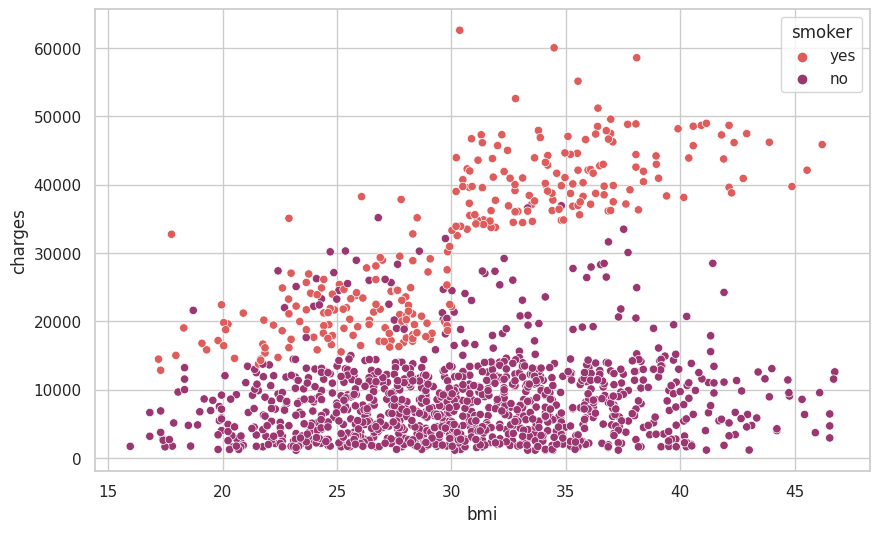

In [56]:
sns.set(style='whitegrid')
f = plt.figure(figsize=(10,6))
sns.scatterplot(x='bmi', y='charges', data=df, palette='flare', hue='smoker');

Sigara içmeyenlerin sigortası daha düşük, içenlerin daha yüksek gibi görünüyor.

Sigara içen ve bmi'si 30'un üzerinde olanların sigortası, sigara içip bmsi 30'un altında olanlara göre daha yüksek.

<ipython-input-63-6258a534660e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)
<ipython-input-63-6258a534660e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr()['charges'])


age         0.302022
bmi         0.193196
children    0.069739
charges     1.000000
Name: charges, dtype: float64


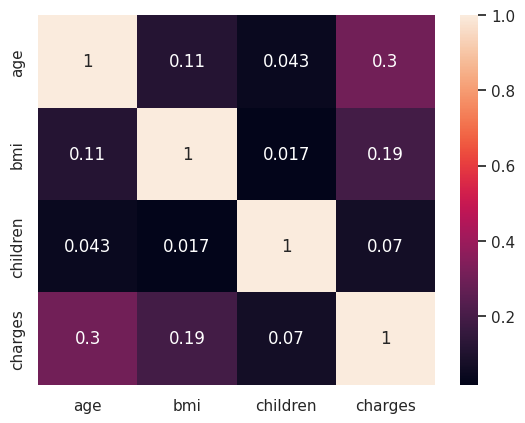

In [63]:
sns.heatmap(df.corr(), annot=True)
print(df.corr()['charges'])

Yaş ve bmi ile charges arasında pozitif korelasyon olduğunu görüyoruz.

Yaş ile charges arasındaki ilişkiye bakalım:

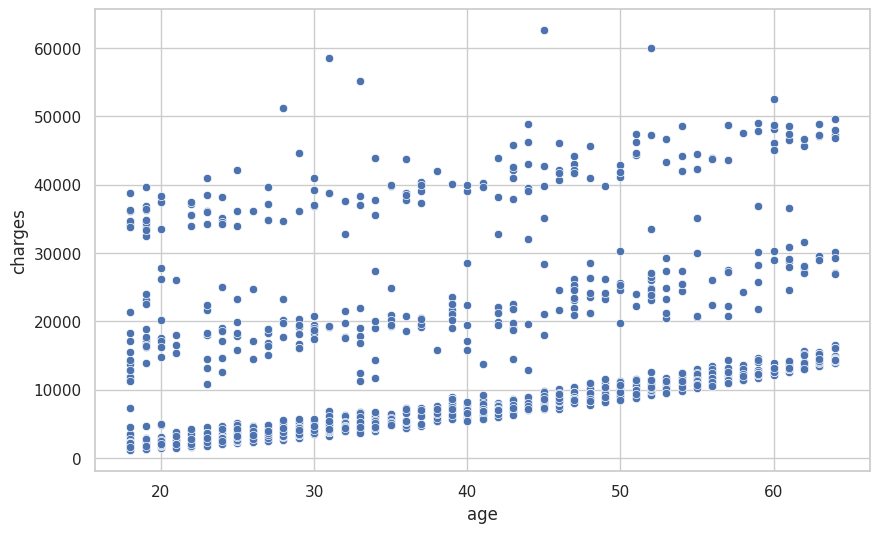

In [58]:
sns.set(style='whitegrid')
f = plt.figure(figsize=(10,6))
sns.scatterplot(x='age', y='charges', data=df);

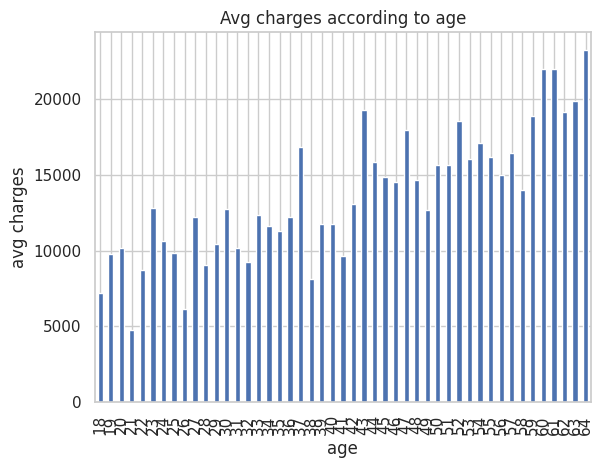

In [71]:
avg_charges = df.groupby("age")["charges"].mean(numeric_only=True)
avg_charges.plot(kind="bar")
plt.xlabel("age")
plt.ylabel("avg charges")
plt.title("Avg charges according to age")
plt.show()

Yaş kolonunu kullanarak yeni 5 kolon oluşturalım:

In [65]:
age_bins = [0, 18, 30, 45, 60, 99]
age_labels = ["0-18", "18-30", "30-45", "45-60", "60+"]

df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, right=False)


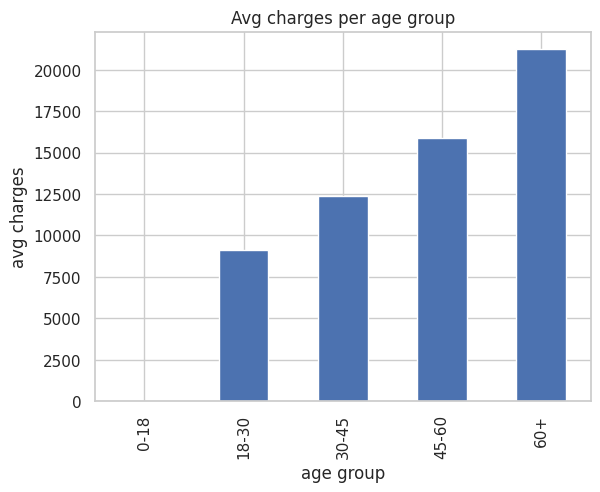

In [72]:
avg_charges_per_age_group = df.groupby("age_group")["charges"].mean(numeric_only=True)
avg_charges_per_age_group.plot(kind="bar")
plt.xlabel("age group")
plt.ylabel("avg charges")
plt.title("Avg charges per age group")
plt.show()

Charges ile bmi arasındaki ilişkiye bakalım:

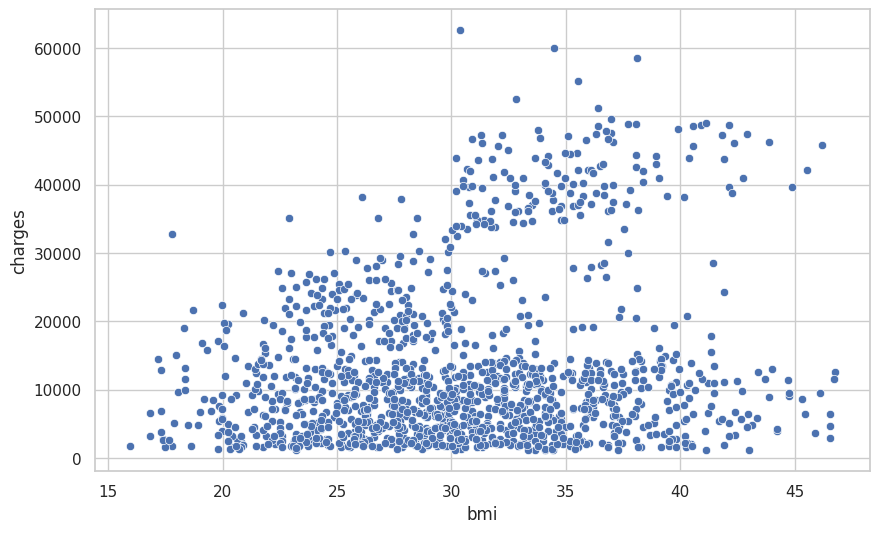

In [73]:
sns.set(style='whitegrid')
f = plt.figure(figsize=(10,6))
sns.scatterplot(x='bmi', y='charges', data=df);

Az önce yaşı 5 yeni kategoriye ayırmıştık, benzer şekilde bmi için de yeni 4 kategori oluşturalım:

In [74]:
bmi_bins = [0, 18.5, 24.9, 29.9, float('inf')]
bmi_labels = ["underweight", "normal weight", "overweight", "obese"]

df["bmi_group"] = pd.cut(df["bmi"], bins=bmi_bins, labels=bmi_labels, right=False)

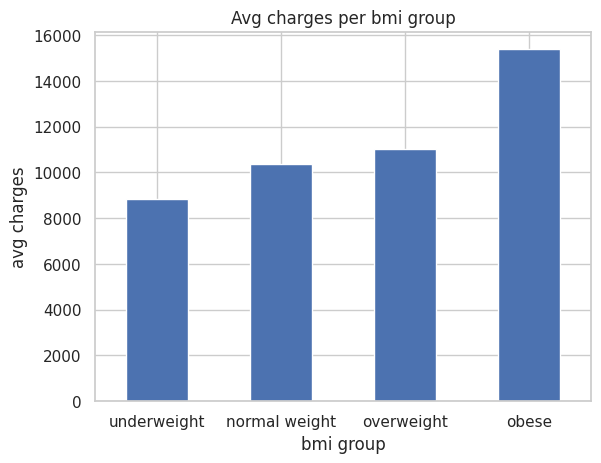

In [77]:
avg_charges_per_bmi_group = df.groupby("bmi_group")["charges"].mean(numeric_only=True)
avg_charges_per_bmi_group.plot(kind="bar")
plt.xlabel("bmi group")
plt.xticks(rotation=0)
plt.ylabel("avg charges")
plt.title("Avg charges per bmi group")
plt.show()

In [78]:
df.head()

,age,sex,bmi,children,smoker,region,charges,age_group,bmi_group
0,19,female,27.900,0,yes,southwest,16884.92400,18-30,overweight
1,18,male,33.770,1,no,southeast,1725.55230,18-30,obese
2,28,male,33.000,3,no,southeast,4449.46200,18-30,obese
3,33,male,22.705,0,no,northwest,21984.47061,30-45,normal weight
4,32,male,28.880,0,no,northwest,3866.85520,30-45,overweight


# **Data Preprocessing**

In [79]:
df = pd.get_dummies(df,
                    columns=['sex','smoker','region', 'age_group','bmi_group'],
                    prefix=['sex','smoker','region', 'age_group','bmi_group'],
                    drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_18-30,age_group_30-45,age_group_45-60,age_group_60+,bmi_group_normal weight,bmi_group_overweight,bmi_group_obese
0,19,27.900,0,16884.92400,0,1,0,0,1,1,0,0,0,0,1,0
1,18,33.770,1,1725.55230,1,0,0,1,0,1,0,0,0,0,0,1
2,28,33.000,3,4449.46200,1,0,0,1,0,1,0,0,0,0,0,1
3,33,22.705,0,21984.47061,1,0,1,0,0,0,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,0,1,0,0,0,1,0


In [81]:
df =df.drop(columns=['age','bmi'])

In [83]:
df.head()

,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_18-30,age_group_30-45,age_group_45-60,age_group_60+,bmi_group_normal weight,bmi_group_overweight,bmi_group_obese
0,0,16884.92400,0,1,0,0,1,1,0,0,0,0,1,0
1,1,1725.55230,1,0,0,1,0,1,0,0,0,0,0,1
2,3,4449.46200,1,0,0,1,0,1,0,0,0,0,0,1
3,0,21984.47061,1,0,1,0,0,0,1,0,0,1,0,0
4,0,3866.85520,1,0,1,0,0,0,1,0,0,0,1,0


Veri setini test ve train olarak ayıralım:

In [85]:
y = df['charges']
X = df.drop(columns='charges', axis=1)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1329, dtype: float64

In [87]:
X

,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_18-30,age_group_30-45,age_group_45-60,age_group_60+,bmi_group_normal weight,bmi_group_overweight,bmi_group_obese
0,0,0,1,0,0,1,1,0,0,0,0,1,0
1,1,1,0,0,1,0,1,0,0,0,0,0,1
2,3,1,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,1,0,0,0,1,0,0,1,0,0
4,0,1,0,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,3,1,0,1,0,0,0,0,1,0,0,0,1
1334,0,0,0,0,0,0,1,0,0,0,0,0,1
1335,0,0,0,0,1,0,1,0,0,0,0,0,1
1336,0,0,0,0,0,1,1,0,0,0,0,1,0


Feature scaling:

In [88]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# **Model Selection**

In [91]:
def crossval(model):
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    forest_reg_rmse_scores = np.sqrt(-scores)
    return forest_reg_rmse_scores.mean()

def basari(gercek, tahmin):
    rmse = mt.mean_squared_error(gercek,tahmin, squared=False)
    r2 = mt.r2_score(gercek, tahmin)
    return[rmse,r2]

In [97]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [95]:
# KNN
knn = KNeighborsRegressor(n_neighbors=10)
knn_model = knn.fit(X_train,y_train)
knn_tahmin = knn_model.predict(X_test)

# AdaBoost
ada = AdaBoostRegressor( n_estimators=50, learning_rate =.01)
ada_model = ada.fit(X_train,y_train)
ada_tahmin = ada_model.predict(X_test)

# Gradient Boosting
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate =.2)
gbr_model = gbr.fit(X_train,y_train)
gbr_tahmin = gbr_model.predict(X_test)

# XGBoost
xgb = XGBRegressor(max_depth = 3, n_estimators=50, learning_rate =.2)
xgb_model = xgb.fit(X_train,y_train)
xgb_tahmin = xgb_model.predict(X_test)

# Linear regresyon
lr = LinearRegression()
linear_model = lr.fit(X_train,y_train)
linear_tahmin = linear_model.predict(X_test)

# Ridge Regresyon
ridge = Ridge()
ridge_model = ridge.fit(X_train, y_train)
ridge_tahmin = ridge_model.predict(X_test)

# Lasso Regresyon
lasso = Lasso()
lasso_model= lasso.fit(X_train, y_train)
lasso_tahmin = lasso_model.predict(X_test)

# ElasticNet Regresyon
elas = ElasticNet()
elas_model = elas.fit(X_train, y_train)
elas_tahmin = elas_model.predict(X_test)

# Decision Tree Regresyon
tree_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_model = tree_regressor.fit(X_train, y_train)
tree_tahmin = tree_model.predict(X_test)

# Random Forest Regresyon
random_for = RandomForestRegressor(random_state=42)
Forest_model = random_for.fit(X_train,y_train)
RandomForest_tahmin = Forest_model.predict(X_test)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e+07, tolerance: 1.517e+07
  model = cd_fast.enet_coordinate_descent(


# **Model Training and Evaluation**

In [96]:
results = [['KNN Model', basari(y_test,knn_tahmin)[0],basari(y_test,knn_tahmin)[1],crossval(knn_model)],
           ['Ada Model', basari(y_test,ada_tahmin)[0],basari(y_test,ada_tahmin)[1],crossval(ada_model)],
           ['GB Model', basari(y_test,gbr_tahmin)[0],basari(y_test,gbr_tahmin)[1],crossval(gbr_model)],
           ['XGB Model', basari(y_test,xgb_tahmin)[0],basari(y_test,xgb_tahmin)[1],crossval(xgb_model)],
           ['Linear Model', basari(y_test,linear_tahmin)[0],basari(y_test,linear_tahmin)[1],crossval(linear_model)],
           ['Ridge Model', basari(y_test,ridge_tahmin)[0],basari(y_test,ridge_tahmin)[1],crossval(ridge_model)],
           ['Lasso Model', basari(y_test,lasso_tahmin)[0],basari(y_test,lasso_tahmin)[1],crossval(lasso_model)],
           ['ElasticNet Model', basari(y_test,elas_tahmin)[0],basari(y_test,elas_tahmin)[1],crossval(elas_model)],
           ['Decision Tree Model', basari(y_test,tree_tahmin)[0],basari(y_test,tree_tahmin)[1],crossval(tree_model)],
           ['Random Forest Model', basari(y_test, RandomForest_tahmin)[0], basari(y_test,RandomForest_tahmin)[1], crossval(Forest_model)]]

columns = ['Model', 'RMSE', 'R2', 'Doğrulama(cv)']

pd.set_option('display.float_format', '{:.3f}'.format)
results = pd.DataFrame(data=results,columns=columns)
results

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e+07, tolerance: 1.366e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e+07, tolerance: 1.380e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e+07, tolerance: 1.376e

,Model,RMSE,R2,Doğrulama(cv)
0,KNN Model,6417.126,0.722,5886.615
1,Ada Model,4712.561,0.850,4810.875
2,GB Model,4499.057,0.863,4704.244
3,XGB Model,4562.688,0.859,4704.457
4,Linear Model,5873.498,0.767,6110.430
5,Ridge Model,5872.673,0.767,6105.026
6,Lasso Model,5872.731,0.767,6105.330
7,ElasticNet Model,6837.385,0.684,6952.441
8,Decision Tree Model,4728.534,0.849,4807.256
9,Random Forest Model,5092.112,0.825,5189.288


En düşük RMSE ve en yüksek R2 değerini GradientBoostingRegressor ile aldık.

# **Hyper-parameter Optimization**

In [98]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate =.2)
params = [{ "max_depth": [2,3,4,5],"n_estimators": [3, 10, 100, 150, 400], "learning_rate": [.2, .02]}]

gbr = GradientBoostingRegressor()

gbr_grid_search = GridSearchCV(gbr, params, cv=5, scoring='neg_mean_squared_error', refit=True)
gbr_grid_search.fit(X, y)
print("En iyi hiperparametre değerleri:", gbr_grid_search.best_params_)

En iyi hiperparametre değerleri: {'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 400}


In [99]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=400, learning_rate =.02)
gbr_model = gbr.fit(X_train,y_train)
gbr_tahmin = gbr_model.predict(X_test)
final_basari= basari(y_test, gbr_tahmin)

In [100]:
final_basari

[4486.040168775451, 0.8641466354074073]